<a href="https://colab.research.google.com/github/teticio/audio-diffusion/blob/master/notebooks/test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
try:
    # are we running on Google Colab?
    import google.colab
    !git clone -q https://github.com/teticio/audio-diffusion.git
    %cd audio-diffusion
    !pip install -q -r requirements.txt
except:
    pass

In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))

In [12]:
import torch
import random
import numpy as np
from datasets import load_dataset
from IPython.display import Audio
from audiodiffusion.mel import Mel
from audiodiffusion import AudioDiffusion

### Select model

In [13]:
#@markdown teticio/audio-diffusion-256                     - trained on my Spotify "liked" playlist

#@markdown teticio/audio-diffusion-breaks-256              - trained on samples used in music

#@markdown teticio/audio-diffusion-instrumental-hiphop-256 - trained on instrumental hiphop

model_id = "../models/ddim-ema-audio-256/"  #@param ["teticio/audio-diffusion-256", "teticio/audio-diffusion-breaks-256", "audio-diffusion-instrumenal-hiphop-256"]

In [14]:
audio_diffusion = AudioDiffusion(model_id=model_id)
mel = Mel(x_res=256, y_res=256)
generator = torch.Generator()

### Run model inference to generate mel spectrogram, audios and loops

Seed = 13546217519375750400


  0%|          | 0/500 [00:00<?, ?it/s]

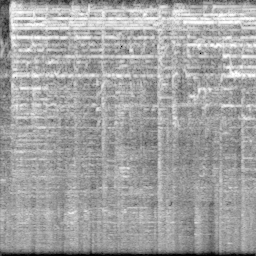

Seed = 18230467057955732031


  0%|          | 0/500 [00:00<?, ?it/s]

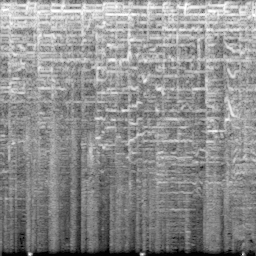

Seed = 17187483613161389671


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
for _ in range(10):
    seed = generator.seed()
    print(f'Seed = {seed}')
    generator.manual_seed(seed)
    image, (sample_rate,
            audio) = audio_diffusion.generate_spectrogram_and_audio(
                steps=500,
                generator=generator)
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = AudioDiffusion.loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")

### Generate variations of audios

Try playing around with `start_steps`. Values closer to zero will produce new samples, while values closer to 1,000 will produce samples more faithful to the original.

  0%|          | 0/50 [00:00<?, ?it/s]

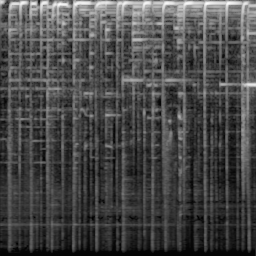

In [7]:
seed = 16183389798189209330  #@param {type:"integer"}
generator.manual_seed(seed)
image, (sample_rate,
        audio) = audio_diffusion.generate_spectrogram_and_audio(
            generator=generator)
display(image)
display(Audio(audio, rate=sample_rate))

  0%|          | 0/100 [00:00<?, ?it/s]

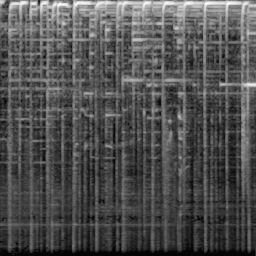

In [9]:
seed = 16183389798189209330  #@param {type:"integer"}
generator.manual_seed(seed)
image, (sample_rate,
        audio) = audio_diffusion.generate_spectrogram_and_audio(
            steps=100,
            generator=generator)
display(image)
display(Audio(audio, rate=sample_rate))

In [ ]:
start_steps = 500  #@param {type:"slider", min:0, max:1000, step:10}
track = AudioDiffusion.loop_it(audio, sample_rate, loops=1)
for variation in range(12):
    image2, (
        sample_rate, audio2
    ) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
        raw_audio=audio,
        start_step=start_steps)
    display(image2)
    display(Audio(audio2, rate=sample_rate))
    track = np.concatenate([track, AudioDiffusion.loop_it(audio2, sample_rate, loops=1)])
display(Audio(track, rate=sample_rate))

### Generate continuations ("out-painting")

In [ ]:
overlap_secs = 2  #@param {type:"integer"}
start_step = 0  #@param {type:"slider", min:0, max:1000, step:10}
overlap_samples = overlap_secs * sample_rate
track = audio
for variation in range(12):
    image2, (
        sample_rate, audio2
    ) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
        raw_audio=audio[-overlap_samples:],
        start_step=start_step,
        mask_start_secs=overlap_secs)
    display(image2)
    display(Audio(audio2, rate=sample_rate))
    track = np.concatenate([track, audio2[overlap_samples:]])
    audio = audio2
display(Audio(track, rate=sample_rate))

### Remix (style transfer)

Alternatively, you can start from another audio altogether, resulting in a kind of style transfer. Maintaining the same seed during generation fixes the style, while masking helps stitch consecutive segments together more smoothly.

In [ ]:
try:
    # are we running on Google Colab?
    from google.colab import files
    audio_file = list(files.upload().keys())[0]
except:
    audio_file = "/home/teticio/Music/liked/El Michels Affair - Glaciers Of Ice.mp3"

In [ ]:
start_step = 500  #@param {type:"slider", min:0, max:1000, step:10}
overlap_secs = 2  #@param {type:"integer"}
mel.load_audio(audio_file)
overlap_samples = overlap_secs * mel.get_sample_rate()
slice_size = mel.x_res * mel.hop_length
stride = slice_size - overlap_samples
generator = torch.Generator()
seed = generator.seed()
print(f'Seed = {seed}')
track = np.array([])
not_first = 0
for sample in range(len(mel.audio) // stride):
    generator.manual_seed(seed)
    audio = np.array(mel.audio[sample * stride:sample * stride + slice_size])
    if not_first:
        # Normalize and re-insert generated audio
        audio[:overlap_samples] = audio2[-overlap_samples:] * np.max(
            audio[:overlap_samples]) / np.max(audio2[-overlap_samples:])
    _, (sample_rate,
        audio2) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
            raw_audio=audio,
            start_step=start_step,
            generator=generator,
            mask_start_secs=overlap_secs * not_first)
    track = np.concatenate([track, audio2[overlap_samples * not_first:]])
    not_first = 1
    display(Audio(track, rate=sample_rate))

### Fill the gap ("in-painting")

In [ ]:
slice = 3  #@param {type:"integer"}
audio = mel.get_audio_slice(slice)
_, (sample_rate,
    audio2) = audio_diffusion.generate_spectrogram_and_audio_from_audio(
        raw_audio=mel.get_audio_slice(slice),
        mask_start_secs=1,
        mask_end_secs=1)
display(Audio(audio, rate=sample_rate))
display(Audio(audio2, rate=sample_rate))

### Compare results with random sample from training set

In [ ]:
ds = load_dataset(model_id)

In [ ]:
image = random.choice(ds['train'])['image']
image

In [ ]:
audio = mel.image_to_audio(image)
Audio(data=audio, rate=mel.get_sample_rate())